# Creating shapefile from results in FireStore

In [1]:
from google.cloud import firestore
from pathlib import Path
from shapely.geometry import Point
from tqdm.notebook import tqdm

import contextily as cx
import geopandas
import pandas as pd
import shapefile
import shutil
import sys


sys.path.insert(0,'..')
from street2sat_utils.client import Prediction, calculate_crop_coords

%matplotlib inline

## Initialize database

In [2]:
# You may need to run the below commands to authenticate GCloud and set the correct project
# !gcloud auth login
# !gcloud config set project bsos-geog-harvest1

In [3]:
db = firestore.Client()
coll = db.collection("street2sat")

## Query data

In [4]:
# Query results from Uganda data (<20,000 rows)
query = coll.where("name", ">", "Uganda-2021-06-23").where("name", "<", "Uganda-2021-06-24").get()
num_yolov5_preds = len(query)
print(f"Number of predictions made: {num_yolov5_preds}")

Number of predictions made: 15198


In [4]:
# Query data from US data (>20,000 rows)
def prefix(i):
    return f"USA-2021-08-20-croptour-{i}GOPRO"

query = []
i = 100
while True:
    current_query = coll.where("name", ">", prefix(i)).where("name", "<", prefix(i+1)).get()
    if len(current_query) == 0:
        break
    query += current_query
    i += 1
    
num_yolov5_preds = len(query)
print(f"Number of predictions made: {num_yolov5_preds}")

Number of predictions made: 80543


## Parse data items into Prediction objects

In [5]:
crop_preds = []
prediction_images_sample = []
for q in query:
    item = q.to_dict()
    results = item["results"]
    if results != [] and item["coord"] != [None, None]:
        tags = {
            "time": item["time"],
            "focal_length": item["focal_length"],
            "pixel_height": item["pixel_height"],
            "coord": item["coord"]
        }
        name = item["name"]
        p = Prediction.from_results_and_tags(results, tags, name)
        crop_preds.append(p)
        
    if "labeled_img" in item:
        prediction_images_sample.append(item)

In [6]:
num_crop_preds = len(crop_preds)
print(f"{round(num_crop_preds / num_yolov5_preds, 4)*100}% of the {num_yolov5_preds} yolov5 predictions had crops") 

74.51% of the 80543 yolov5 predictions had crops


## Analyze Images

In [7]:
def get_url(item, multiple_accounts=True):
    host = "https://storage.cloud.google.com/"
    url = item['labeled_img'].replace("gs://", host)
    if multiple_accounts:
        url += "?authuser=1"
    return url

def analyze(item):
    print(f"Prediction: {item['distances']}")
    print(f"See image: {get_url(item)}")

In [8]:
analyze(prediction_images_sample[10])

Prediction: {'sugarcane': 14.029434650446202}
See image: https://storage.cloud.google.com/street2sat-model-predictions/USA/2021-08-20-croptour/100GOPRO/result_G0014129.jpg?authuser=1


## Estimate coordinates of crops

In [9]:
crop_preds = calculate_crop_coords(crop_preds)

## Create dataframe for dataset

In [10]:
def crop_preds_to_df(crop_preds):
    list_of_dicts = []
    for p in crop_preds:
        for crop, new_coord in p.crop_coord.items():
            list_of_dicts.append({
                "crop": crop,
                "lat": new_coord[0],
                "lon": new_coord[1],
                "time": p.time,
                "original_lat": p.coord[0],
                "original_lon": p.coord[1]
            })
    return pd.DataFrame(list_of_dicts)

In [11]:
# Plain dataframe
df = crop_preds_to_df(crop_preds)
df.head()

,crop,lat,lon,time,original_lat,original_lon
0,sugarcane,41.209291,-84.355242,2021-08-16 09:53:45+00:00,41.209293,-84.355544
1,sugarcane,41.209070,-84.355675,2021-08-16 09:53:47+00:00,41.209276,-84.355544
2,sugarcane,41.209271,-84.355862,2021-08-16 09:53:47+00:00,41.209271,-84.355545
3,sugarcane,41.209261,-84.355953,2021-08-16 09:53:48+00:00,41.209261,-84.355547
4,sugarcane,41.209253,-84.355918,2021-08-16 09:53:49+00:00,41.209254,-84.355548


In [12]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat, crs='EPSG:4326'))

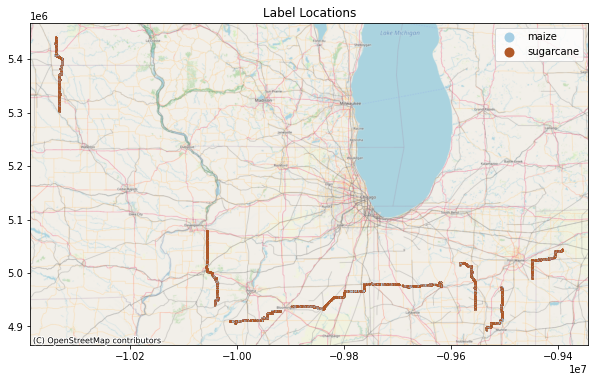

In [13]:
ax = gdf.to_crs('EPSG:3857').plot(
    figsize=(10, 30), 
    marker='o', 
    column='crop', 
    categorical=True,
    markersize=1,
    cmap='Paired',
    legend=True
)
ax.set_title("Label Locations")
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

## Create shapefile for dataset

In [14]:
def crop_preds_to_shapefile(crop_preds, dataset_name, target_dir="../temp"):
    dataset_dir = f"{target_dir}/{dataset_name}"
    target = f"{dataset_dir}/{dataset_name}"

    # Create shapefile
    w = shapefile.Writer(target=target, shape=shapefile.POINT)
    w.field("Latitude", "N", decimal=30)
    w.field("Longitude", "N", decimal=30)
    w.field("Crop Type", "C")
    for p in crop_preds:
        for crop, new_coord in p.crop_coord.items():
            w.point(new_coord[1], new_coord[0])
            w.record(new_coord[0], new_coord[1], crop)
    w.close()

    # Create projection file
    prj = open(f"{target}.prj", "w")
    epsg = 'GEOGCS["WGS 84",'
    epsg += 'DATUM["WGS_1984",'
    epsg += 'SPHEROID["WGS 84",6378137,298.257223563]]'
    epsg += ',PRIMEM["Greenwich",0],'
    epsg += 'UNIT["degree",0.0174532925199433]]'
    prj.write(epsg)
    prj.close()

    # Create zipfile
    shutil.make_archive(dataset_dir, 'zip', dataset_dir)
    return dataset_dir

In [15]:
shp_file =  crop_preds_to_shapefile(crop_preds, dataset_name="USA-2021-08-20-croptour")
shp_file

'../temp/USA-2021-08-20-croptour'